<a href="https://colab.research.google.com/github/StatsPoet/Berlin-SDL-WS2122/blob/main/temperature_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/image_analysis/temperatur"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/image_analysis/temperatur

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
!pip install colour-science

     |████████████████████████████████| 2.1 MB 8.0 MB/s 


In [ ]:
#listings = pd.read_csv("listings.csv")

Ddependencies

In [ ]:
import PIL
import pandas as pd
from PIL import Image
from PIL import ImageStat
import numpy as np
import os
import colour


In order to not run into runtime error, the code below must be run, so that every picture in the folder is available to this script. Repeat running the code chunk until ir runs without error. This ensures that the loop over all images can run through. 

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/airbnb_scraper/pictures/pictures_2st_half_8750_to_full"
pic_paths = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))] 


In [ ]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import pickle
infile = open("/content/drive/MyDrive/Colab Notebooks/airbnb_scraper/Munich_scraper_files/paths_munich",'rb')
pic_paths = pickle.load(infile)
infile.close()

Create data frame in which data will be stored

In [ ]:
pic_full_num = []
pic_id = []
pic_num = []
for i in range(len(pic_paths)):
  try: 
    number = pic_paths[i]
    number = number.split("pictures_munich/") #has to be adjusted to the dir of the pictures
    number = number[1]
    number = number.split(".0")
    number = number[0] + number[1]
    number = number.split(".")
    number = number[0]
    pic_full_num.append(number)
    pic_id.append(int(number.split("_")[0]))
    pic_num.append(int(number.split("_")[1]))
  except:
    print(i)

In [ ]:
all_pictures_df = pd.DataFrame(
    {"pic_paths": pic_paths, "pic_full_num": pic_full_num, "pic_id": pic_id, "pic_num": pic_num}
)

In [ ]:
max_pic_amount = max(pic_num) + 1
max_pic_amount

18

In [ ]:
all_pictures_df[0:5]

,pic_paths,pic_full_num,pic_id,pic_num
0,/content/drive/MyDrive/Colab Notebooks/airbnb_...,51668654_6,51668654,6
1,/content/drive/MyDrive/Colab Notebooks/airbnb_...,51668654_7,51668654,7
2,/content/drive/MyDrive/Colab Notebooks/airbnb_...,51668654_8,51668654,8
3,/content/drive/MyDrive/Colab Notebooks/airbnb_...,51668654_9,51668654,9
4,/content/drive/MyDrive/Colab Notebooks/airbnb_...,51668654_10,51668654,10


In [ ]:
better_data_frame = all_pictures_df.groupby('pic_id', as_index=False).agg(lambda x: x.tolist())

In [ ]:
for i in range(max_pic_amount):
  name = "color_temp_pic_" + str(i)
  better_data_frame[name] = [0] * len(better_data_frame)
# adds columns with 0 for each class

In [ ]:
better_data_frame = better_data_frame.drop(["pic_full_num"], axis = 1)

In [ ]:
import math
math.ceil(len(better_data_frame) / 4)

728

In [ ]:
len(better_data_frame)

2909

In [ ]:
better_data_frame = better_data_frame[:5]

In [ ]:
better_data_frame.index= range(len(better_data_frame))

In [ ]:
better_data_frame

,pic_id,pic_paths,pic_num,color_temp_pic_0,color_temp_pic_1,color_temp_pic_2,color_temp_pic_3,color_temp_pic_4,color_temp_pic_5,color_temp_pic_6,color_temp_pic_7,color_temp_pic_8,color_temp_pic_9,color_temp_pic_10,color_temp_pic_11,color_temp_pic_12,color_temp_pic_13,color_temp_pic_14,color_temp_pic_15,color_temp_pic_16,color_temp_pic_17
0,97945,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114695,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,127383,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,159634,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,170154,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,53680711,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2905,53703888,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4, 5, 6]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2906,53730546,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2907,53748144,[/content/drive/MyDrive/Colab Notebooks/airbnb...,"[0, 1, 2, 3, 4]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


using k-means to find the domninant colours in the picture. Determin CCT. The base code was taken from stack overflow https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv

In [ ]:
import cv2
from skimage import io
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

for i in range(len(better_data_frame)):
  m = min(better_data_frame.loc[i,"pic_num"])
  for j in range(len(better_data_frame.loc[i,"pic_num"])):
    try:

      img = io.imread(better_data_frame.loc[i,"pic_paths"][j])

      pixels = np.float32(img.reshape(-1, 3))

      n_colors = 3
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
      flags = cv2.KMEANS_RANDOM_CENTERS

      _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
      _, counts = np.unique(labels, return_counts=True)


      CCT_list = []
      for k in range(palette.shape[0]):

        # Assuming sRGB encoded colour values.
        RGB = palette[k]

        # Conversion to tristimulus values.
        XYZ = colour.sRGB_to_XYZ(RGB / 255)

        # Conversion to chromaticity coordinates.
        xy = colour.XYZ_to_xy(XYZ)

        # Conversion to correlated colour temperature in K.
        CCT = colour.xy_to_CCT(xy, 'hernandez1999')
        CCT_list.append(CCT)
        
        better_data_frame.iloc[i, (m+j+3)] = np.mean(CCT_list)
    except:
      better_data_frame.iloc[i, (m+j+3)] = np.nan
      continue
      
  print(i)

import pickle

filename = "/content/drive/MyDrive/Colab Notebooks/image_analysis/temperatur/mun_cct_df"
better_data_frame.to_pickle(filename)

18834337

In [ ]:
import pickle
infile = open("/content/drive/MyDrive/Colab Notebooks/image_analysis/temperatur/mun_cct_df",'rb')
better_data_frame = pickle.load(infile)
infile.close()

In [ ]:
cct_mean = []
for i in range(len(better_data_frame)):
  pic_amount = len(better_data_frame.loc[i,"pic_num"])
  cct_mean.append(better_data_frame.iloc[i,3:(3+pic_amount)].mean(axis=0))

cct_mean

better_data_frame.insert(3,"cct_mean", cct_mean)

In [ ]:
better_data_frame_0_9 = better_data_frame.loc[:,:"color_temp_pic_9"]

In [ ]:
better_data_frame_0_9 = better_data_frame_0_9.drop(labels = ["pic_paths", "pic_num"],axis = 1).copy()

In [ ]:
better_data_frame_0_9

In [ ]:
better_data_frame_0_9

,pic_id,cct_mean,color_temp_pic_0,color_temp_pic_1,color_temp_pic_2,color_temp_pic_3,color_temp_pic_4,color_temp_pic_5,color_temp_pic_6,color_temp_pic_7,color_temp_pic_8,color_temp_pic_9
0,97945,5.448949e+03,4631.069919,5204.051660,6312.993025,5.849549e+03,6381.524080,5904.500446,5189.958529,5065.885330,5357.825333,4592.137816
1,114695,4.436633e+03,4755.133885,5403.978217,5494.933442,5.381487e+03,4707.289637,4866.363075,4413.773040,2902.833097,3147.306687,3293.231329
2,127383,5.139188e+03,4643.486194,5618.207226,4894.561791,5.090469e+03,5429.791853,5394.159356,5019.393702,5186.350548,4732.262932,5409.361546
3,159634,4.868684e+03,4584.245896,3289.972836,4760.685065,5.745763e+03,2288.224260,2926.732482,9014.818414,5989.882764,3629.124845,2856.973555
4,170154,4.499686e+03,4080.408625,4596.532590,4265.779257,3.855735e+03,5174.683980,4667.814294,4464.409381,4312.310951,4590.621311,4988.559309
...,...,...,...,...,...,...,...,...,...,...,...,...
2904,53680711,4.525007e+03,6726.900059,4459.389371,3250.202397,3.580346e+03,4608.198727,0.000000,0.000000,0.000000,0.000000,0.000000
2905,53703888,5.902844e+03,5361.475304,4367.900204,4448.157721,4.699990e+03,13158.454830,4580.377538,4703.553657,0.000000,0.000000,0.000000
2906,53730546,inf,4524.303353,5240.529386,5550.861936,inf,5566.532465,0.000000,0.000000,0.000000,0.000000,0.000000
2907,53748144,5.778837e+16,4524.679397,7356.421634,4138.431186,2.889419e+17,4444.098224,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/image_analysis/temperatur/cct_dataframes/cct_df_mun"
better_data_frame_0_9.to_pickle(filename)

# Plot dominent colours of pictures

In [ ]:
import pandas as pd
import cv2
from skimage import io
from PIL import ImageFile

In [ ]:
dir = "/content/drive/MyDrive/Showcase_Image Analysis/Raw pic"
pic_paths = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))] 

In [ ]:
pic_full_num = []
pic_id = []
pic_num = []
for i in range(len(pic_paths)):
  try: 
    number = pic_paths[i]
    number = number.split("Raw pic/") #has to be adjusted to the dir of the pictures
    number = number[1]
    number = number.split(".")
    number = number[0]
    pic_full_num.append(number)
    pic_id.append(int(number.split("_")[0]))
    pic_num.append(int(number.split("_")[1]))
  except:
    print(i)

In [ ]:
all_pictures_df = pd.DataFrame(
    {"pic_paths": pic_paths, "pic_full_num": pic_full_num, "pic_id": pic_id, "pic_num": pic_num}
)

In [ ]:
all_pictures_df.sort_values("pic_num", inplace = True, ignore_index = True)

In [ ]:
all_pictures_df

,pic_paths,pic_full_num,pic_id,pic_num
0,/content/drive/MyDrive/Showcase_Image Analysis...,23509544_1,23509544,1
1,/content/drive/MyDrive/Showcase_Image Analysis...,52386640_1,52386640,1
2,/content/drive/MyDrive/Showcase_Image Analysis...,52386640_6,52386640,6


In [ ]:
img = io.imread(all_pictures_df.loc[0,"pic_paths"])

pixels = np.float32(img.reshape(-1, 3))

n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)


CCT_list = []
for k in range(palette.shape[0]):

        # Assuming sRGB encoded colour values.
  RGB = palette[k]

        # Conversion to tristimulus values.
  XYZ = colour.sRGB_to_XYZ(RGB / 255)

        # Conversion to chromaticity coordinates.
  xy = colour.XYZ_to_xy(XYZ)

        # Conversion to correlated colour temperature in K.
  CCT = colour.xy_to_CCT(xy, 'hernandez1999')
  CCT_list.append(CCT)
        
showcase_mean = round(np.mean(CCT_list),0)

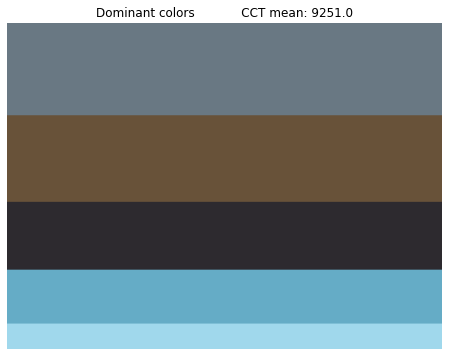

In [ ]:
import matplotlib.pyplot as plt

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0) = plt.subplots(1, 1, figsize=(12,6))
ax0.imshow(dom_patch)
ax0.set_title('Dominant colors' + "            " + "CCT mean:" + " " + str(showcase_mean))
ax0.axis('off')
plt.show(fig)

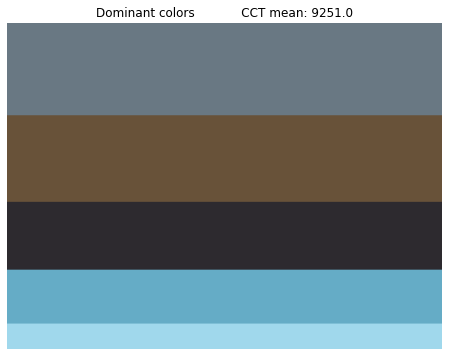

In [ ]:
import matplotlib.pyplot as plt

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0) = plt.subplots(1, 1, figsize=(12,6))
ax0.imshow(dom_patch)
ax0.set_title('Dominant colors' + "            " + "CCT mean:" + " " + str(showcase_mean))
ax0.axis('off')
plt.savefig("/content/drive/MyDrive/Showcase_Image Analysis/dominant_col/cold_2")
plt.show(fig)